In [1]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import numpy             as np
import pandas            as pd
import xarray            as xr
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import netCDF4
import math
import yaml
import sys
import os

from   pylab             import cm
from   scipy             import ndimage
from   numpy             import inf
from   itertools         import groupby

NaN = np.nan
import warnings
warnings.filterwarnings("ignore")

sys.path.append('/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/python_modules')
from domain         import generate_domain_coord
from domain         import convert_latlon_to_domain_indices
from satellite      import extract_satellite_track

working_directory = '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/1_CALIPSO_LowMidHigh_cloudcover'
yml_file = working_directory + '/../config.yml'
stream = open(yml_file,'r')
config = yaml.safe_load(stream)

# Time Period definition

In [2]:
year   = 2014
period = 'DJF'

if   period == 'DJF'   : months = [ 1,  2, 12]
elif period == 'MAM'   : months = [ 3,  4,  5]
elif period == 'JJA'   : months = [ 6,  7,  8]
elif period == 'SON'   : months = [ 9, 10, 11]
elif period == 'ANNUAL': months = [ 1,  2,  3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
else:                    months = [ int(period) ]

dirlist = config['CALIPSO']['list']

### COMPLETE filelist 2014-2015
filelist   = dirlist + '/NAM11/' + '2014.txt'
df         = pd.read_csv(filelist,delimiter='\s+', header=None)
df.columns = ['file', 'ndata', 'ti', 'tf', 'date', 'MM', 'date_gem', 't_gem']
df         = df[   np.isin(df['MM'], months)  ].reset_index(drop=True)

In [3]:
filepath_CALIPSO = '/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/YYYY'

t_gem        = df['t_gem'   ][0]
YYYY_gem     = str(df['date_gem'][0])[0:4]
YYYYMMDD_gem = str(df['date_gem'][0])
YYYYMM_gem   = str(df['date_gem'][0])[0:6]
date         = str(df['date'    ][0])
MM           = str(df['date_gem'][0])[4:6]

CALIPSO_file = df['file'][2].split('/')[8]
CALIPSO_nc   = filepath_CALIPSO.replace('YYYY',YYYY_gem) +'/'+ CALIPSO_file

nc = netCDF4.Dataset(CALIPSO_nc, 'r')

# MASKING

In [4]:
#########################################################################
# Altitude and pressure limit for High, Mid, Low layer. See eg          #
# : https://climserv.ipsl.polytechnique.fr/cfmip-obs/Calipso_goccp.html #
#########################################################################
pressure_lim_midlow  =  680 # hPa
pressure_lim_midhigh =  440 # hPa

# HIGH, MID and LOW cloud cover masks #
Pressure  = nc['Pressure'][:]
mask_high = np.where(Pressure <  pressure_lim_midhigh,  1, NaN)
mask_low  = np.where(Pressure >= pressure_lim_midlow ,  1, NaN)
mask_mid  = np.where(Pressure >= pressure_lim_midhigh,  1, NaN) * np.where(Pressure < pressure_lim_midlow , 1, NaN)

# Using masks to keep only the sublayers associated to the given layer (Low,Mid,High)
Cloud_Layer_Fraction      = nc['Cloud_Layer_Fraction'][:] / 30 # /30, because there is 30 measures per gridpoints 
Cloud_Layer_Fraction_high = Cloud_Layer_Fraction * mask_high
Cloud_Layer_Fraction_mid  = Cloud_Layer_Fraction * mask_mid
Cloud_Layer_Fraction_low  = Cloud_Layer_Fraction * mask_low

# TEST OVERLAP DEFINITION

# 1.1 Maximum overlap

In [5]:
max_Cloud_Cover      = np.nanmax(Cloud_Layer_Fraction     , axis = 1)                                                             
max_Cloud_Cover_high = np.nanmax(Cloud_Layer_Fraction_high, axis = 1)
max_Cloud_Cover_mid  = np.nanmax(Cloud_Layer_Fraction_mid , axis = 1)
max_Cloud_Cover_low  = np.nanmax(Cloud_Layer_Fraction_low , axis = 1)

# 1.2 Minimum overlap

In [6]:
min_Cloud_Cover      = np.nansum(Cloud_Layer_Fraction     , axis = 1); min_Cloud_Cover      = np.where(min_Cloud_Cover      <= 1, min_Cloud_Cover     , 1)                                                          
min_Cloud_Cover_high = np.nansum(Cloud_Layer_Fraction_high, axis = 1); min_Cloud_Cover_high = np.where(min_Cloud_Cover_high <= 1, min_Cloud_Cover_high, 1)
min_Cloud_Cover_mid  = np.nansum(Cloud_Layer_Fraction_mid , axis = 1); min_Cloud_Cover_mid  = np.where(min_Cloud_Cover_mid  <= 1, min_Cloud_Cover_mid , 1)
min_Cloud_Cover_low  = np.nansum(Cloud_Layer_Fraction_low , axis = 1); min_Cloud_Cover_low  = np.where(min_Cloud_Cover_low  <= 1, min_Cloud_Cover_low , 1)

# 1.3 Mean overlap

In [7]:
mean_Cloud_Cover      = np.nanmean(Cloud_Layer_Fraction     ,axis=1)
mean_Cloud_Cover_high = np.nanmean(Cloud_Layer_Fraction_high,axis=1)
mean_Cloud_Cover_mid  = np.nanmean(Cloud_Layer_Fraction_mid ,axis=1)
mean_Cloud_Cover_low  = np.nanmean(Cloud_Layer_Fraction_low ,axis=1)

# 1.4 Random overlap

In [8]:
def random_overlap(nc_array):
    ran_overlap = np.zeros(nc_array.shape[0])

    for index,row in pd.DataFrame(nc_array).iterrows():
        one_minus_cover = np.array([1 - (x) for x in row])
        filtered        = one_minus_cover[~np.isnan(one_minus_cover)]
        ran_overlap[index] = 1 - math.prod(filtered)        
    return ran_overlap

ran_Cloud_Cover      = random_overlap(Cloud_Layer_Fraction     )                                                             
ran_Cloud_Cover_high = random_overlap(Cloud_Layer_Fraction_high)
ran_Cloud_Cover_mid  = random_overlap(Cloud_Layer_Fraction_mid )
ran_Cloud_Cover_low  = random_overlap(Cloud_Layer_Fraction_low )

# 1.5 Maximum-Random overlap (Block method)

In [9]:
def block(nc_array):
    return [list(v) for k,v in groupby(nc_array, key = lambda x: x != 0)]# if k != 0]

def random_overlap_block(blocks):
    one_minus_cover = np.array([1 - (x) for x in blocks])
    #filtered        = one_minus_cover[~np.isnan(one_minus_cover)]
    ran_overlap = 1 - math.prod(one_minus_cover)    
    return ran_overlap

def max_ran(nc_array):
    maxran_overlap = np.zeros(nc_array.shape[0])
    for index,profiles in pd.DataFrame(nc_array).iterrows():
        cleaned_profile = [x for x in profiles if not np.isnan(x)] # removing nan and missing elements
        blocks = block(cleaned_profile)  # Splitting cloud layers in blocks when clear sky
        max_blocks = [np.nanmax(x) for x in blocks]
        #input('')
        #print('Clean profile :\n',cleaned_profile)
        #print('Cloud blocks  :\n',blocks)
        #print('Max blocks   :\n',max_blocks)
        if 0.0 in profiles: # Random overlap part if we have clear sky
            #print('___________________________________')
            #print('***** Random overlap *****')
            maxran_overlap[index] = random_overlap_block(max_blocks)
            #print('___________________________________')
        else: # Maximum overlap part if we have a full profile of data
            #print('___________________________________')
            #print('***** Maximum overlap *****')
            #print('___________________________________')
            maxran_overlap[index] = np.nanmax(cleaned_profile)
        #print('maxran_overlap = ',maxran_overlap[index])
            
    return maxran_overlap

maxran_Cloud_Cover      = max_ran(Cloud_Layer_Fraction     )
maxran_Cloud_Cover_high = max_ran(Cloud_Layer_Fraction_high)
maxran_Cloud_Cover_mid  = max_ran(Cloud_Layer_Fraction_mid )
maxran_Cloud_Cover_low  = max_ran(Cloud_Layer_Fraction_low )

# 1.6 Maximum-Random overlap (Geleyn and Hollingsworth, 1979)

In [64]:
'Maximum between two layers'
def max_layers(C1,C2):
    return np.nanmax(np.array(C1,C2))
'Minimum between two layers'
def min_layers(C1): 
    theta = 1. - 1.e-6
    return np.nanmin(np.array([C1,theta], dtype=np.float64))
'Max-Random overlap'
def max_random(nc_array):
    maxran_overlap = np.zeros(nc_array.shape[0])
    for index,row in pd.DataFrame(nc_array).iterrows():
        list_prod = np.zeros(len(row)-1)
        for i in range(1,len(row)-1):
            #input(' ')
            #print(np.array(row))
            list_prod[i] = (1-max_layers(row[i-1],row[i]))/(1-row[i-1])
            #print(list_prod)
        filtered        = list_prod[~np.isnan(list_prod)]
        maxran_overlap[index] = 1 - (1-row[0])*math.prod(filtered)
        
    return maxran_overlap

# Plot test

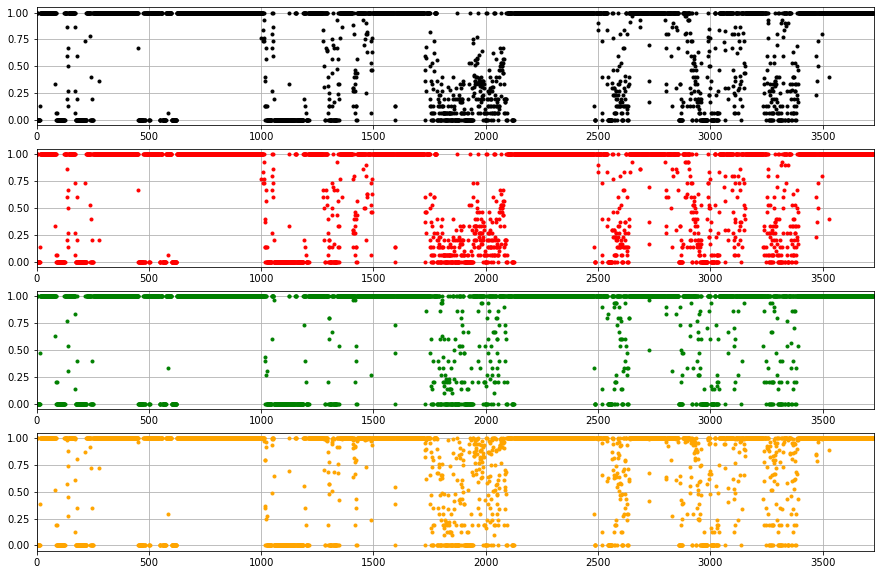

In [10]:
fig,ax = plt.subplots(4,1, figsize = (15,10))
ax[0].plot(maxran_Cloud_Cover     , '.',color = 'k'  )
ax[1].plot(max_Cloud_Cover        , '.',color = 'r'  )
ax[2].plot(min_Cloud_Cover        , '.',color = 'g'  )
ax[3].plot(ran_Cloud_Cover        , '.',color = 'orange'  )

#ax[1].plot(maxran_Cloud_Cover_high, '|',color ='r'   )
#ax[2].plot(maxran_Cloud_Cover_mid , '|',color ='g'   )
#ax[3].plot(maxran_Cloud_Cover_low , '|',color ='orange')
for i in range(4):
    ax[i].grid(axis = 'both')
    ax[i].margins(x = 0)